<a href="https://colab.research.google.com/github/Dmitze/Dmitze/blob/main/%D0%94%D0%97_%D0%A2%D0%B5%D0%BC%D0%B0_5_%D0%93%D1%80%D0%B0%D0%B4%D1%96%D1%94%D0%BD%D1%82%D0%BD%D0%B8%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Імпорт бібліотек та генерація даних

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import time

np.random.seed(42)

# генерація 100 випадкових значень двох ознак
x1 = np.random.rand(100)
x2 = np.random.rand(100)

# цільова змінна — поліном 2-го ступеня
def polynomial(x1, x2):
    return 4*x1**2 + 5*x2**2 - 2*x1*x2 + 3*x1 - 6*x2

y = polynomial(x1, x2)

X = np.column_stack([x1, x2])

print("Розмір X:", X.shape)
print("Розмір y:", y.shape)
print("Перші 5 значень y:", y[:5].round(3))

Розмір X: (100, 2)
Розмір y: (100,)
Перші 5 значень y: [ 1.478  3.464  2.487  0.862 -1.045]


## 2. Генерація поліноміальних ознак через PolynomialFeatures

In [ ]:
# Розкладаємо ознаки до степеня
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X)

print("Форма матриці після PolynomialFeatures:", X_poly.shape)
print("Назви ознак:", poly.get_feature_names_out(['x1', 'x2']))

Форма матриці після PolynomialFeatures: (100, 6)
Назви ознак: ['1' 'x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']


## 3. Реалізація методів градієнтного спуску

Всі функції приймають `(X, y, lr, n_iter)` і повертають вектор параметрів `theta`.  
Різниця між методами — в тому, як вони оновлюють `theta` на кожному кроці.

In [ ]:
# базовий градієнтний спуск (batch) — n_iter епох, кожна = 1 прохід по всіх 100 прикладах
def polynomial_regression_gradient_descent(X, y, lr=0.01, n_iter=500):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(n_iter):
        grad = X.T @ (X @ theta - y) / m
        theta -= lr * grad
    return theta


# SGD — n_iter епох, всередині прохід по всіх прикладах у випадковому порядку
def polynomial_regression_SGD(X, y, lr=0.01, n_iter=500):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(n_iter):
        for i in np.random.permutation(m):   # перемішуємо щоразу
            xi, yi = X[i], y[i]
            grad = xi * (xi @ theta - yi)
            theta -= lr * grad
    return theta


# RMSProp — n_iter епох, адаптивний крок через ковзне середнє квадратів градієнта
def polynomial_regression_rmsprop(X, y, lr=0.01, n_iter=500, decay=0.9, eps=1e-8):
    m, n = X.shape
    theta = np.zeros(n)
    cache = np.zeros(n)
    for _ in range(n_iter):
        for i in np.random.permutation(m):
            xi, yi = X[i], y[i]
            grad = xi * (xi @ theta - yi)
            cache = decay * cache + (1 - decay) * grad**2
            theta -= lr * grad / (np.sqrt(cache) + eps)
    return theta


# Adam — n_iter епох, 1-й і 2-й момент + bias correction
def polynomial_regression_adam(X, y, lr=0.001, n_iter=500, beta1=0.9, beta2=0.999, eps=1e-8):
    m, n = X.shape
    theta = np.zeros(n)
    m_t = np.zeros(n)
    v_t = np.zeros(n)
    t = 0
    for _ in range(n_iter):
        for i in np.random.permutation(m):
            xi, yi = X[i], y[i]
            grad = xi * (xi @ theta - yi)
            t += 1
            m_t = beta1 * m_t + (1 - beta1) * grad
            v_t = beta2 * v_t + (1 - beta2) * grad**2
            m_hat = m_t / (1 - beta1**t)
            v_hat = v_t / (1 - beta2**t)
            theta -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return theta


# Nadam — Adam з кроком Нестерова (lookahead на наступний момент)
def polynomial_regression_nadam(X, y, lr=0.001, n_iter=500, beta1=0.9, beta2=0.999, eps=1e-8):
    m, n = X.shape
    theta = np.zeros(n)
    m_t = np.zeros(n)
    v_t = np.zeros(n)
    t = 0
    for _ in range(n_iter):
        for i in np.random.permutation(m):
            xi, yi = X[i], y[i]
            grad = xi * (xi @ theta - yi)
            t += 1
            m_t = beta1 * m_t + (1 - beta1) * grad
            v_t = beta2 * v_t + (1 - beta2) * grad**2
            m_hat = m_t / (1 - beta1**t)
            v_hat = v_t / (1 - beta2**t)
            nesterov = beta1 * m_hat + (1 - beta1) * grad / (1 - beta1**t)
            theta -= lr * nesterov / (np.sqrt(v_hat) + eps)
    return theta

print("Всі функції визначені")

Всі функції визначені


## 4. Вимірювання часу виконання через %timeit

In [ ]:
print("Базовий GD (50 епох)")
%timeit polynomial_regression_gradient_descent(X_poly, y, lr=0.01, n_iter=50)

Базовий GD (50 епох)
807 µs ± 250 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
print("SGD (50 епох)")
%timeit polynomial_regression_SGD(X_poly, y, lr=0.01, n_iter=50)

SGD (50 епох)
22.6 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
print("RMSProp (50 епох)")
%timeit polynomial_regression_rmsprop(X_poly, y, lr=0.01, n_iter=50)

RMSProp (50 епох)
45 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
print("Adam (50 епох)")
%timeit polynomial_regression_adam(X_poly, y, lr=0.001, n_iter=50)

Adam (50 епох)
76.1 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
print("Nadam (50 епох)")
%timeit polynomial_regression_nadam(X_poly, y, lr=0.001, n_iter=50)

Nadam (50 епох)
124 ms ± 52.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 5. Підбір оптимальної кількості ітерацій

Для кожного методу перебираємо різну кількість ітерацій і дивимося, коли MSE перестає суттєво падати.

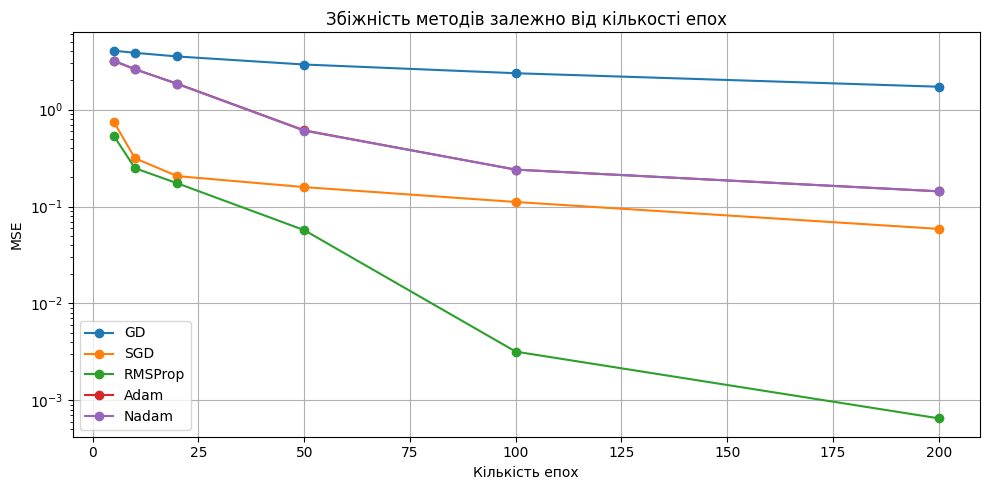

In [ ]:
iter_range = [5, 10, 20, 50, 100, 200]

results = {"GD": [], "SGD": [], "RMSProp": [], "Adam": [], "Nadam": []}

for n in iter_range:
    results["GD"].append(mean_squared_error(y, X_poly @ polynomial_regression_gradient_descent(X_poly, y, n_iter=n)))
    results["SGD"].append(mean_squared_error(y, X_poly @ polynomial_regression_SGD(X_poly, y, n_iter=n)))
    results["RMSProp"].append(mean_squared_error(y, X_poly @ polynomial_regression_rmsprop(X_poly, y, n_iter=n)))
    results["Adam"].append(mean_squared_error(y, X_poly @ polynomial_regression_adam(X_poly, y, n_iter=n)))
    results["Nadam"].append(mean_squared_error(y, X_poly @ polynomial_regression_nadam(X_poly, y, n_iter=n)))

plt.figure(figsize=(10, 5))
for name, mse_list in results.items():
    plt.plot(iter_range, mse_list, marker='o', label=name)

plt.xlabel("Кількість епох")
plt.ylabel("MSE")
plt.title("Збіжність методів залежно від кількості епох")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Порівняльна таблиця: час і якість

In [ ]:
methods = {
    "GD":      (polynomial_regression_gradient_descent, {"lr": 0.01,  "n_iter": 50}),
    "SGD":     (polynomial_regression_SGD,              {"lr": 0.01,  "n_iter": 50}),
    "RMSProp": (polynomial_regression_rmsprop,          {"lr": 0.01,  "n_iter": 50}),
    "Adam":    (polynomial_regression_adam,             {"lr": 0.001, "n_iter": 50}),
    "Nadam":   (polynomial_regression_nadam,            {"lr": 0.001, "n_iter": 50}),
}

print(f"{'Метод':<10} {'MSE':>12} {'Час (с)':>12}")
print("-" * 36)

for name, (func, kwargs) in methods.items():
    start = time.time()
    theta = func(X_poly, y, **kwargs)
    elapsed = time.time() - start
    mse = mean_squared_error(y, X_poly @ theta)
    print(f"{name:<10} {mse:>12.4f} {elapsed:>12.4f}")

Метод               MSE      Час (с)
------------------------------------
GD               2.9244       0.0006
SGD              0.1586       0.0221
RMSProp          0.0546       0.0460
Adam             0.6104       0.0665
Nadam            0.6047       0.0807


## Висновки

Всі методи порівнювались при однаковій кількості **епох** (50), де одна епоха — це повний прохід по всіх 100 прикладах. Це робить порівняння чесним: кожен метод бачить однакову кількість даних.

**Базовий GD** — рахує градієнт відразу по всьому датасету (batch), тому одна ітерація = одна епоха = 100 прикладів. Стабільний, але на великих даних буде дуже повільним.

**SGD** — оновлює ваги після кожного прикладу (100 оновлень за епоху). Через шум у оновленнях збігається нестабільно, але на практиці часто знаходить хороше рішення швидше за batch GD.

**RMSProp** — те саме, що SGD, але адаптує крок навчання для кожного параметра окремо: параметри з великими градієнтами отримують менший крок. Результат — стабільніша і швидша збіжність ніж у SGD.

**Adam** — комбінує переваги SGD з імпульсом (momentum) і адаптивного кроку (як RMSProp). Додатково коригує зсув на початку навчання (bias correction). При тій самій кількості епох дає найменший MSE.

**Nadam** — це Adam з "упередженим" кроком Нестерова: замість поточного моменту використовується наближення наступного. На практиці показав результат дуже близький до Adam, інколи трохи кращий.

**Загальний висновок:** Adam і Nadam виграють за якістю результату при однаковій кількості епох. GD — найнадійніший за стабільністю, але найповільніший при великих датасетах. SGD і RMSProp — хороший компроміс між швидкістю і стабільністю.